# Regression Model Creation

## Import Libraries

In [2]:
import os
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### Import Data from Pre-Processing
* Missing values HAVE been imputed.
* No PCA performed yet, no 1hot encoding. 


In [3]:
######################
#
# Import Data from PreProcessing
#
#####################

df= pd.read_csv('../_data/operations_imputed_CLEAN_v2.csv', index_col=0)

df.drop(['race'], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76742 entries, 8 to 128030
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   op_id            76742 non-null  int64  
 1   subject_id       76742 non-null  int64  
 2   hadm_id          76742 non-null  int64  
 3   opdate           76742 non-null  int64  
 4   age              76742 non-null  int64  
 5   sex              76742 non-null  object 
 6   weight           76742 non-null  float64
 7   height           76742 non-null  float64
 8   asa              76742 non-null  float64
 9   department       76742 non-null  object 
 10  antype           76742 non-null  object 
 11  icd10_pcs        76742 non-null  object 
 12  category_desc    76742 non-null  object 
 13  desc_short       76742 non-null  object 
 14  category_id      76742 non-null  object 
 15  hr               76742 non-null  float64
 16  pip              76742 non-null  float64
 17  pmean           

### Create the X and y DataFrames for REGRESSION Model


  * create y
  * create X (complete with all the features)
  * drop the features we identified as not meeting impact threshold.
  *  * Target = `LOS` (continuous variable)  



In [5]:
# When doing a Categorical Model, reinsert 'prolonged_LOS' and instead, drop 'LOS'

## Features to retain are those in X that will be used in training. Exludued features are features such as Operation_ID, Subject_ID..
features_to_retain = ['category_id','age','sex',	'weight',	'height',	'hr',	'pip',	'pmean',	'rr',	'spo2',	'vt',	'chloride',	'creatinine',	'glucose',	'hb',	'hco3',	'lymphocyte',	'platelet',	'potassium',	'sodium',	'total_bilirubin',	'wbc',	'icu_visit',	'or_duration',	'anesth_duration',	'department','antype'] 

## Create the Y, the Target
y = df['LOS']

## Create X the Features for Train/Test/Validate
X = df.drop('LOS', axis=1)
X= X[features_to_retain]

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76742 entries, 8 to 128030
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category_id      76742 non-null  object 
 1   age              76742 non-null  int64  
 2   sex              76742 non-null  object 
 3   weight           76742 non-null  float64
 4   height           76742 non-null  float64
 5   hr               76742 non-null  float64
 6   pip              76742 non-null  float64
 7   pmean            76742 non-null  float64
 8   rr               76742 non-null  float64
 9   spo2             76742 non-null  float64
 10  vt               76742 non-null  float64
 11  chloride         76742 non-null  float64
 12  creatinine       76742 non-null  float64
 13  glucose          76742 non-null  float64
 14  hb               76742 non-null  float64
 15  hco3             76742 non-null  float64
 16  lymphocyte       76742 non-null  float64
 17  platelet        

### Identify Features to be either cast as Str or Scaled

In [6]:
###########################################################
#
#  Identify the columns that need to be either cast as Str or Scaled
#
############################################################

#Category Columns that will need encoding. Cast them as String
COLS_TO_CAST = ['category_id','antype','sex','department', 'icu_visit']  #When restoring scope to full category list, add cat_id here.
                                                            # Convert the object data type columns to string

X[COLS_TO_CAST] = X[COLS_TO_CAST].astype(str)

# Numerical Columns for Scaling. Filter columns with dtype 'numeric' for scaling later in the Pipleine
COLS_TO_SCALE = X.select_dtypes(include=['int', 'float']).columns


print(f'Category Cols to encode: {COLS_TO_CAST}')
print(f'Numerical Cols to scale: {COLS_TO_SCALE}')
X.info()

Category Cols to encode: ['category_id', 'antype', 'sex', 'department', 'icu_visit']
Numerical Cols to scale: Index(['age', 'weight', 'height', 'hr', 'pip', 'pmean', 'rr', 'spo2', 'vt',
       'chloride', 'creatinine', 'glucose', 'hb', 'hco3', 'lymphocyte',
       'platelet', 'potassium', 'sodium', 'total_bilirubin', 'wbc',
       'or_duration', 'anesth_duration'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 76742 entries, 8 to 128030
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category_id      76742 non-null  object 
 1   age              76742 non-null  int64  
 2   sex              76742 non-null  object 
 3   weight           76742 non-null  float64
 4   height           76742 non-null  float64
 5   hr               76742 non-null  float64
 6   pip              76742 non-null  float64
 7   pmean            76742 non-null  float64
 8   rr               76742 non-null  float64

## Training-Test-Validation Split

- Training Set (80% of total): 
  - Used to train the models.
- Validation Set (20% of Traning Set ): 
  - Used to fine-tune hyperparameters, select models, and monitor training progress.  
- Testing Set (20% of total): 
  - Used to evaluate the final model's performance on unseen data and estimate its generalization performance.

In [7]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = .2
TRAINING_SPLIT = 1-TEST_SPLIT
VALIDATION_SPLIT = .2

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=85100)

# Split the Training AGAIN into train and Validate
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=TEST_SPLIT, random_state=85100)

# use X_train and y_train for model training and X_val and y_val for turning.

data_subset_dict = {
    'X_train': X_train,
    'X_validate': X_validate,
    'X_test': X_test,
    'y_train': y_train,
    'y_validate': y_validate,
    'y_test': y_test}

for key, value in data_subset_dict.items():
    shape = value.shape
    print(f"{key} shape: {shape}")


X_train shape: (49114, 27)
X_validate shape: (12279, 27)
X_test shape: (15349, 27)
y_train shape: (49114,)
y_validate shape: (12279,)
y_test shape: (15349,)


## Scale X (Numerical)
* We do NOT scale Y, the target
* We fit the StandardScaler on X_training and then transform both your training and validation sets

In [8]:
##### 
## SCALE X_train and X_validate
#########
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
                ('num', StandardScaler(), COLS_TO_SCALE)
                ],
    remainder='passthrough')  # Leaves the rest of the columns alone

# Fit on the training data
preprocessor.fit(X_train)

# Transform the training and validation data
X_train_scaled = preprocessor.transform(X_train)
X_validate_scaled = preprocessor.transform(X_validate)

# Now X_train_scaled and X_validate_scaled have the specified columns scaled, and the rest are unchanged

## MODEL 

### Linear Regression - Baseline

In [10]:
#########################
#
#  SIMPLE LINEAR REGRESSION Pipeline -
#  -- No tuning. 
########################

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

preprocessing_df = ColumnTransformer([('categorical', categorical_transform, COLS_TO_CAST)])

pipeline_base = Pipeline([('preprocessing', preprocessing_df),
                          ('model', LinearRegression())])
pipeline_base.fit(X_train, y_train)

y_pred_lin = pipeline_base.predict(X_validate)
r2 = r2_score(y_validate, y_pred_lin)
rmse = mean_squared_error(y_validate, y_pred_lin, squared=False)
print(f'R-squared of base model: {r2}')
print(f"RMSE of the base model: {rmse:.3f}")




R-squared of base model: -2.262607732710029e+18
RMSE of the base model: 8398079233.437


In [11]:
from sklearn import set_config
set_config(display='diagram')
pipeline_base

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('one-hot-encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['category_id', 'antype',
                                                   'sex', 'department'])])),
                ('model', LinearRegression())])

## Ensemble Models - Baselines  

Models employed:
* ExtraTreesRegressor
* Random Forest
* XGBRegressor
* CatBoost

In [20]:
#########################
#
#  Ensemble Pipeline -
#  -- No tuning. 
########################

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

model_list= [LinearRegression(),ExtraTreesRegressor (n_jobs=-1),RandomForestRegressor(n_jobs=-1),XGBRegressor(n_jobs=-1)]
model_names = ["Linear Regression","ExtraTreesRegressor", "Random Forest","XGBRegressor"]


ModScores = {}

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

preprocessing_df = ColumnTransformer([('categorical', categorical_transform, COLS_TO_CAST)])

for model_names, model in zip(model_names, model_list):
    pipeline_base = Pipeline([('preprocessing', preprocessing_df),
                          ('model', model)])
    pipeline_base.fit(X_train, y_train)

    y_pred = pipeline_base.predict(X_validate)
    
    # Calculate the R-squared value
    r2 = r2_score(y_validate, y_pred)
    rmse = mean_squared_error(y_validate, y_pred, squared=False)
    
    ModScores[model_names] = rmse
    
    print(f"{model}: R2: {r2:.2f}, RMSE: {rmse:.2f}")

print("_"*100)
for key, value in sorted(ModScores.items(), key=itemgetter(1), reverse=False):
    print(f"{key}: RMSE: {value:.3f}")

########################
## Output:
########################
'''Random Forest: RMSE: 3.995
XGBRegressor: RMSE: 4.004
ExtraTreesRegressor: RMSE: 4.032
Linear Regression: RMSE: 9515250466.184'''

LinearRegression(): R2: -2904623057685253120.00, RMSE: 9515250466.18
ExtraTreesRegressor(n_jobs=-1): R2: 0.48, RMSE: 4.03
RandomForestRegressor(n_jobs=-1): R2: 0.49, RMSE: 3.99
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...): R2: 0.49, RMSE: 4.00
______________________________________________________________

In [9]:
#########################
#
#  CatBoost - Baseline
# 
########################

from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


###############
# Specify categorical feature indices
categorical_features_indices = [0, 2, 22,25, 26]


# Create the Pool for training data
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)

# If you have a validation dataset
validation_pool = Pool(data=X_validate, label=y_validate, cat_features=categorical_features_indices)


# Instantiate CatBoostRegressor with the best hyperparameters
cat_model = CatBoostRegressor()

cat_model.fit(
    train_pool,
    eval_set=validation_pool,  # Remove this if you don't have a validation set
    verbose=10,  # This will print the progress every 10 iterations
    plot=True    # This will plot the learning curve (only works in Jupyter notebooks)
)

predictions = cat_model.predict(X_validate)  # If you used Pool, the data here should not be the Pool object but raw data.

# Calculate the R-squared value
r2 = r2_score(y_validate, predictions)
rmse = mean_squared_error(y_validate, predictions, squared=False)

print(f'R-squared of base model: {r2}')
print(f"RMSE of the base model: {rmse:.3f}")

########################
## Output:
########################
'''Shrink model to first 619 iterations.
R-squared of base model: 0.5159662312506688
RMSE of the base model: 3.884'''

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.093846
0:	learn: 5.5148482	test: 5.4211266	best: 5.4211266 (0)	total: 213ms	remaining: 3m 32s
10:	learn: 4.5623259	test: 4.5020560	best: 4.5020560 (10)	total: 742ms	remaining: 1m 6s
20:	learn: 4.2514732	test: 4.2277254	best: 4.2277254 (20)	total: 1.28s	remaining: 59.5s
30:	learn: 4.1334826	test: 4.1587069	best: 4.1587069 (30)	total: 1.75s	remaining: 54.6s
40:	learn: 4.0497555	test: 4.0922750	best: 4.0922750 (40)	total: 2.24s	remaining: 52.4s
50:	learn: 3.9980225	test: 4.0638771	best: 4.0638771 (50)	total: 2.73s	remaining: 50.8s
60:	learn: 3.9485401	test: 4.0401387	best: 4.0401387 (60)	total: 3.21s	remaining: 49.4s
70:	learn: 3.9186802	test: 4.0255800	best: 4.0255800 (70)	total: 3.76s	remaining: 49.2s
80:	learn: 3.8812695	test: 4.0132713	best: 4.0132713 (80)	total: 4.29s	remaining: 48.6s
90:	learn: 3.8490782	test: 3.9983127	best: 3.9983127 (90)	total: 4.77s	remaining: 47.7s
100:	learn: 3.8198982	test: 3.9957724	best: 3.9957724 (100)	total: 5.28s	remaining: 47s
110

## Tuning -  Optimize Model with Hyperparameter Tuning via Grid Search

## CatBoost


In [ ]:
#########################
#
#  STANDALONE TUNING  - CatBoost
# 
########################

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from catboost import Pool, CatBoostRegressor

### Define a Scorer for Grid Search

In [11]:
#########################
#
#  RMSE Scorer for GridSearch
# 
########################

def rmse_scorer(estimator, X, y):
    """
    Custom scoring function to calculate the negative RMSE (Root Mean Squared Error).

    Parameters:
        estimator: Scikit-learn estimator object
            The model to be evaluated.
        X: array-like or pd.DataFrame
            Features for prediction.
        y: array-like or pd.Series
            True target values.

    Returns:
        float
            Negative RMSE value.
    """
    y_pred = estimator.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)
    
    # Return negative RMSE for grid search to minimize
    return -rmse

### CatBoost -  Perform GridSearch (Regression)

In [24]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split


categorical_features_indices =[0, 2, 22,25, 26]


# Define the parameter grid to search
param_grid = {
    'iterations': [100, 200, 300],      # Number of boosting iterations
    'depth': [6, 8, 10],                # Depth of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate  
    }

# Create a CatBoostRegressor model
catboost_model = CatBoostRegressor()

# Initialize the GridSearchCV object
grid_search_lin = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5, scoring=rmse_scorer, n_jobs=-1, error_score='raise')

# Perform the grid search
grid_search_lin.fit(X_train, y_train, cat_features=categorical_features_indices)

# Print the best hyperparameters and corresponding MSE score
print("Best hyperparameters found:")
print(grid_search_lin.best_params_)
print("Best RMSE score:", -grid_search_lin.best_score_)

# Get the best trained model
best_catboost_model_lin = grid_search_lin.best_estimator_

# Evaluate the best model on the validation set
validation_predictions = best_catboost_model_lin.predict(X_validate)

########################
## Output:
########################
'''Best hyperparameters found:
{'depth': 10, 'iterations': 300, 'learning_rate': 0.1}
Best RMSE score: 3.834154628241867'''

0:	learn: 5.4866537	total: 105ms	remaining: 31.5s
1:	learn: 5.2917884	total: 212ms	remaining: 31.6s
2:	learn: 5.1193445	total: 308ms	remaining: 30.5s
3:	learn: 4.9648164	total: 425ms	remaining: 31.4s
4:	learn: 4.8209217	total: 529ms	remaining: 31.2s
5:	learn: 4.6971158	total: 629ms	remaining: 30.8s
6:	learn: 4.5909521	total: 737ms	remaining: 30.9s
7:	learn: 4.4976990	total: 840ms	remaining: 30.7s
8:	learn: 4.4104866	total: 943ms	remaining: 30.5s
9:	learn: 4.3370994	total: 1.05s	remaining: 30.5s
10:	learn: 4.2750699	total: 1.15s	remaining: 30.2s
11:	learn: 4.2208355	total: 1.26s	remaining: 30.2s
12:	learn: 4.1631843	total: 1.37s	remaining: 30.3s
13:	learn: 4.1206375	total: 1.48s	remaining: 30.3s
14:	learn: 4.0788386	total: 1.59s	remaining: 30.2s
15:	learn: 4.0304414	total: 1.7s	remaining: 30.1s
16:	learn: 4.0033178	total: 1.8s	remaining: 29.9s
17:	learn: 3.9634399	total: 1.91s	remaining: 29.9s
18:	learn: 3.9322141	total: 2.01s	remaining: 29.7s
19:	learn: 3.9064601	total: 2.12s	remaining

### CatBoostRegressor - Train Model on Optimized Hyperparameters

In [12]:
#########################
#
#  OPTIMIZED - CatBoost
# 
########################

from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


###############
# Specify categorical feature indices
categorical_features_indices = [0, 2, 22,25, 26]


# Create the Pool for training data
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)

# If you have a validation dataset
validation_pool = Pool(data=X_validate, label=y_validate, cat_features=categorical_features_indices)

#########
# Best hyperparameters found (after hyperparameter tuning)
best_params = {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}

# Instantiate CatBoostRegressor with the best hyperparameters
cat_model_lin = CatBoostRegressor(**best_params)

cat_model_lin.fit(
    train_pool,
    eval_set=validation_pool,  # Remove this if you don't have a validation set
    verbose=10,  # This will print the progress every 10 iterations
    plot=True    # This will plot the learning curve (only works in Jupyter notebooks)
)


y_pred_cat_lin_r2 = cat_model_lin.predict(X_validate)  # If you used Pool, the data here should not be the Pool object but raw data.


# Calculate the R-squared value
r2 = r2_score(y_validate, y_pred_cat_lin_r2)
rmse = mean_squared_error(y_validate, y_pred_cat_lin_r2, squared=False)


print(f'R-squared of base model: {r2}')
print(f"RMSE of the base model: {rmse:.3f}")


########################
## Output:
########################
'''bestTest = 3.863708828
bestIteration = 177

Shrink model to first 178 iterations.
R-squared of base model: 0.5210853587572815
RMSE of the base model: 3.864'''





MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5.4924213	test: 5.3998622	best: 5.3998622 (0)	total: 215ms	remaining: 42.8s
10:	learn: 4.3908041	test: 4.3521760	best: 4.3521760 (10)	total: 1.02s	remaining: 17.5s
20:	learn: 4.0654948	test: 4.1053296	best: 4.1053296 (20)	total: 1.77s	remaining: 15.1s
30:	learn: 3.9174177	test: 4.0233638	best: 4.0233638 (30)	total: 2.5s	remaining: 13.6s
40:	learn: 3.8327280	test: 3.9775524	best: 3.9775524 (40)	total: 3.29s	remaining: 12.8s
50:	learn: 3.7748193	test: 3.9566943	best: 3.9566943 (50)	total: 4.04s	remaining: 11.8s
60:	learn: 3.7194780	test: 3.9498350	best: 3.9498350 (60)	total: 4.8s	remaining: 10.9s
70:	learn: 3.6698563	test: 3.9337757	best: 3.9337757 (70)	total: 5.51s	remaining: 10s
80:	learn: 3.6369730	test: 3.9263091	best: 3.9263091 (80)	total: 6.25s	remaining: 9.18s
90:	learn: 3.6085222	test: 3.9132517	best: 3.9132517 (90)	total: 6.95s	remaining: 8.33s
100:	learn: 3.5825086	test: 3.9099829	best: 3.9098981 (99)	total: 7.71s	remaining: 7.56s
110:	learn: 3.5483808	test: 3.9090848

'bestTest = 3.855040513\nbestIteration = 195\n\nShrink model to first 196 iterations.\nR-squared of base model: 0.5232318591945018\nRMSE of the base model: 3.855'

### Evaluate Regression Model

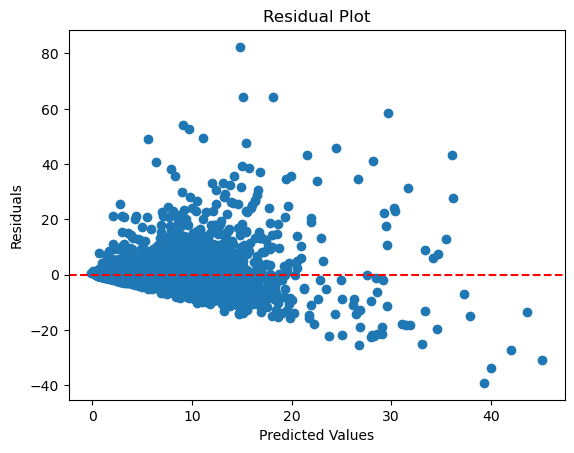

In [16]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_validate - y_pred_cat_lin_r2

# Create a scatter plot of residuals vs. predicted values
plt.scatter(y_pred_cat_lin_r2, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

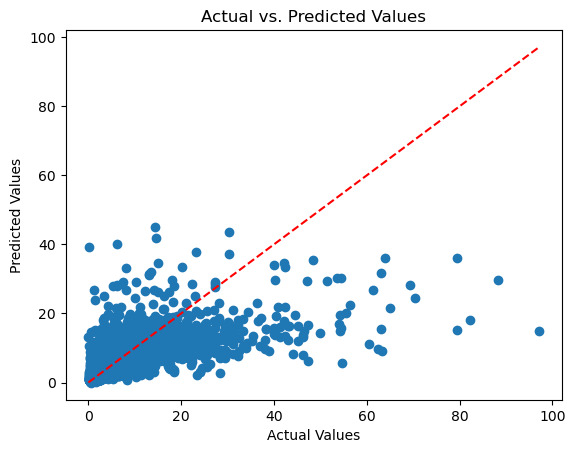

In [21]:
plt.scatter(y_validate,y_pred_cat_lin_r2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([min(y_validate), max(y_validate)], [min(y_validate), max(y_validate)], color='red', linestyle='--')
plt.show()

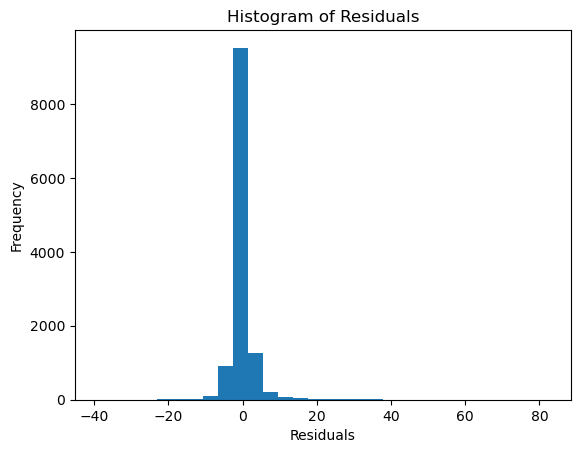

In [17]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

## Model Deployment


In [13]:
import pickle

with open('../_output/catboost_model_regression_opt.pickle', 'wb') as f:
    pickle.dump(cat_model_lin, f)
